# Gaussian Target Practice

In [1]:
] activate "../"

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
using Distributions
using ForwardDiff
using LinearAlgebra
using Random

using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

## MCHMC

In [3]:
d = 100
e = sqrt.(randn(d).^2)
m = Vector(LinRange(1, 100, d))
cov_mat = Matrix(Diagonal(e));

In [4]:
gaussian_target = GaussianTarget(m, cov_mat);
gaussian_spl = MCHMC(0.0, 0.5; varE_wanted=0.5, sigma=ones(d));

In [5]:
gaussian_samples_mchmc = Sample(gaussian_spl, gaussian_target, 1_000_000;
                          dialog=true);

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: 0.7167283126256873
eps: 0.40257434416256016 --> VarE: 0.489232777887384


[ Info: Found eps: 0.40257434416256016 ✅


In [6]:
gaussian_d1_mchmc = [sample[1] for sample in gaussian_samples_mchmc]
gaussian_d50_mchmc = [sample[50] for sample in gaussian_samples_mchmc];

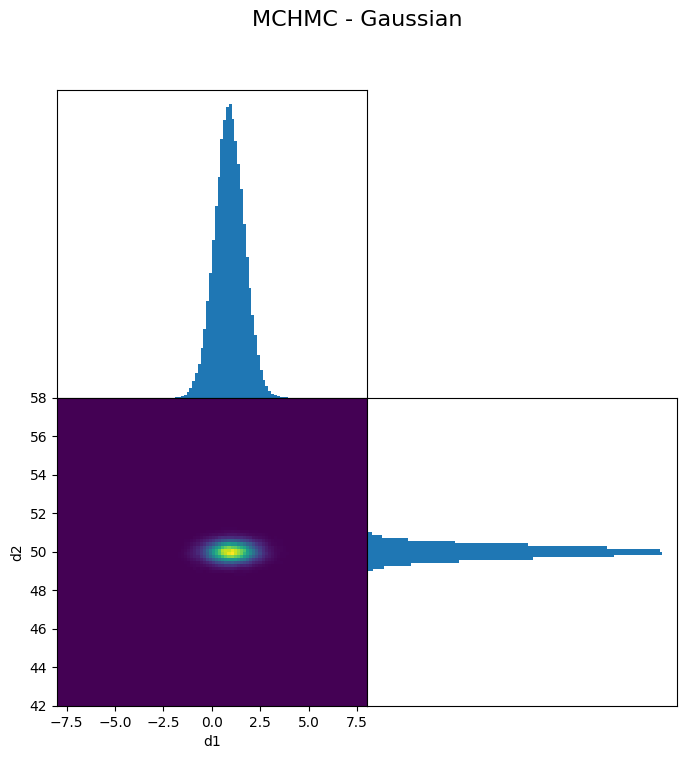

In [7]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("MCHMC - Gaussian", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(gaussian_d1_mchmc, bins=100, range=[-8,8])
axis[1,1].set_yticks([])

axis[2,2].hist(gaussian_d50_mchmc, bins=100, orientation="horizontal", range=[42, 58])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(gaussian_d1_mchmc, gaussian_d50_mchmc, bins=100, range=[[-8,8],[42, 58]])
axis[2,1].set_xlabel("d1")
axis[2,1].set_ylabel("d2");

## NUTS

In [8]:
using AdvancedHMC
using LogDensityProblems

In [9]:
# Define the target distribution using the `LogDensityProblem` interface
struct LogTargetDensity
    dim::Int
end
LogDensityProblems.logdensity(p::LogTargetDensity, θ) = -gaussian_target.nlogp(θ) #-sum(abs2, θ) / 2  # standard multivariate normal
LogDensityProblems.dimension(p::LogTargetDensity) = p.dim
LogDensityProblems.capabilities(::Type{LogTargetDensity}) = LogDensityProblems.LogDensityOrder{0}()

In [10]:
# Choose parameter dimensionality and initial parameter value
initial_θ = gaussian_target.prior_draw(0.0)
ℓπ = LogTargetDensity(d)

# Set the number of samples to draw and warmup iterations
n_samples, n_adapts = 10_000, 1_000

# Define a Hamiltonian system
metric = DiagEuclideanMetric(d)
hamiltonian = Hamiltonian(metric, ℓπ, ForwardDiff)

# Define a leapfrog solver, with initial step size chosen heuristically
initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
integrator = AdvancedHMC.Leapfrog(initial_ϵ)

# Define an HMC sampler, with the following components
#   - multinomial sampling scheme,
#   - generalised No-U-Turn criteria, and
#   - windowed adaption for step-size and diagonal mass matrix
proposal = NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))

# Run the sampler to draw samples from the specified Gaussian, where
#   - `samples` will store the samples
#   - `stats` will store diagnostic statistics for each sample
gaussian_samples_hmc, stats = sample(hamiltonian, proposal, initial_θ, n_samples, adaptor, n_adapts; progress=true)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Sampling 100%|███████████████████████████████| Time: 0:03:17
  iterations:                    10000
  n_steps:                       7
  is_accept:                     true
  acceptance_rate:               0.9447265179486772
  log_density:                   -113.66425306574186
  hamiltonian_energy:            167.66334618952354
  hamiltonian_energy_error:      -0.1852310726108044
  max_hamiltonian_energy_error:  -0.1852310726108044
  tree_depth:                    3
  numerical_error:               false
  step_size:                     0.44574479791804655
  nom_step_size:                 0.445744

([[0.3656131405072957, 0.7226541043382083, -0.4235701331416519, 0.9238965390016374, 0.05741185404699296, -0.898424938485582, -1.4502484651223355, 1.6744222844609182, 0.047496404618936526, -0.5551678184996907  …  -0.6588951809028668, -0.29470993293485875, -1.0490723565152718, -1.4898827753159665, -0.3396515818604589, -0.3579839152565572, -1.499850031028413, -0.6399263553050983, -1.1174274725938358, 0.012891122384488921], [0.3656131405072957, 0.7226541043382083, -0.4235701331416519, 0.9238965390016374, 0.05741185404699296, -0.898424938485582, -1.4502484651223355, 1.6744222844609182, 0.047496404618936526, -0.5551678184996907  …  -0.6588951809028668, -0.29470993293485875, -1.0490723565152718, -1.4898827753159665, -0.3396515818604589, -0.3579839152565572, -1.499850031028413, -0.6399263553050983, -1.1174274725938358, 0.012891122384488921], [0.38640515982579376, 0.9384773263267887, -0.408464005961876, 5.949235677818937, 0.4861278431051774, -0.6079406718720302, -0.8358746535775148, 1.445724510

In [11]:
gaussian_d1_hmc = [sample[1] for sample in gaussian_samples_hmc]
gaussian_d50_hmc = [sample[50] for sample in gaussian_samples_hmc];

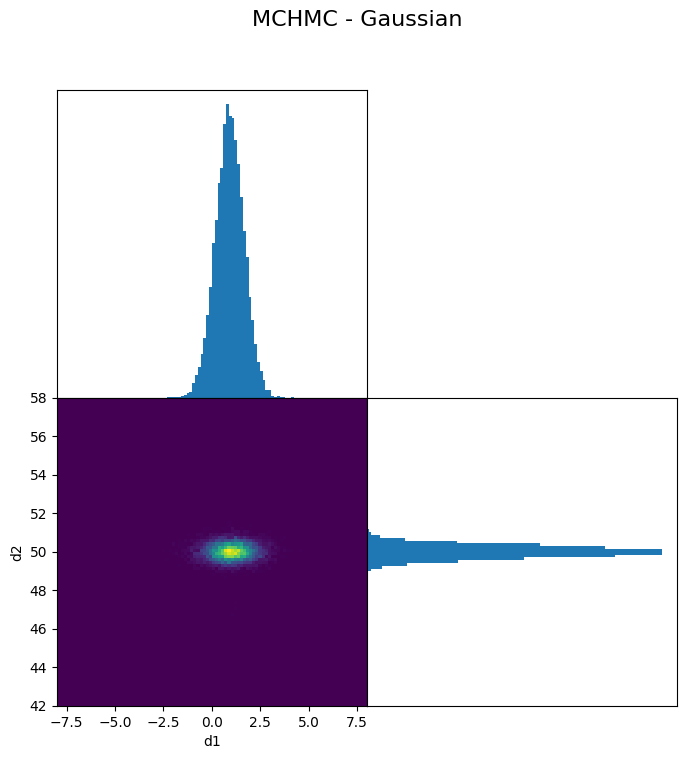

In [12]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("MCHMC - Gaussian", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(gaussian_d1_hmc, bins=100, range=[-8,8])
axis[1,1].set_yticks([])

axis[2,2].hist(gaussian_d50_hmc, bins=100, orientation="horizontal", range=[42, 58])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(gaussian_d1_hmc, gaussian_d50_hmc, bins=100, range=[[-8,8],[42, 58]])
axis[2,1].set_xlabel("d1")
axis[2,1].set_ylabel("d2");